# Numerical computation of the Kernel $U(m)$

## Introduction

For $m_1, m_2 \in \mathbb{Z}$, let $S$ be an inverse Gamma distribution of parameters $\alpha$ and $\beta$ given by $\alpha=2$, $\beta=\frac{m_1^2+m_2^2}{4}$.

Let $B_t$ be the standard planar Brownian motion starting at the origin.

For $H_t(x) = \sum_{m\in\mathbb{Z}^2} (2\pi t)^{-1}\exp(-\|x-m\|^2/(2t))$ for $x\in\mathbb{R}^2$, we define $U(m)= E[1/H_{S}(B_{S}/\sqrt{2}+(m_{1}/2,m_{2}/2)]$.

The goal is to compute $U(m)$ using Monte Carlo method.

The motivation stems from the recent paper on discrete second Riesz transforms and their probabilistic analogues by Daesung Kim and Rodrigo Banuelos.


## Computation

First, we import NumPy for numerical computations, numba for fast, parallel computation, and Matplotlib for visualization. 

In [6]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

To compute $U(m)$, 
1. Sample $S$ from Inverse Gamma distribution.
2. Sample the planar Brownian motion $B=(B_x, B_y)$ at time $S$.
3. Truncate the infinite sum in $H$ with respect to $S$ and $(m_1, m_2)$.
4. Compute the finite sum.

In [2]:
@njit(fastmath=True)
def compute_U_m(m1, m2, N_samples, K_trunc):
    beta = (m1*m1 + m2*m2) / 4.0
    if beta == 0.0:
        return 0.0
    acc = 0.0
    for _ in range(N_samples):
        # sample S from InvGamma(2, beta)
        t = np.random.gamma(2.0, 1.0 / beta)
        S = 1.0 / t
        # sample planar Brownian motion B=(Bx, By) at time S
        sigma = np.sqrt(S)
        Bx = np.random.normal(0.0, sigma)
        By = np.random.normal(0.0, sigma)
        X1 = Bx / np.sqrt(2.0) + m1 / 2.0
        X2 = By / np.sqrt(2.0) + m2 / 2.0
        # truncation for H
        K = int(np.ceil(K_trunc + 3.0 * np.sqrt(S) + max(abs(m1), abs(m2))))
        H = 0.0
        norm = 2.0 * np.pi * S
        # lattice sum 
        for ki in range(-K, K + 1):
            dx = X1 - ki
            for kj in range(-K, K + 1):
                dy = X2 - kj
                H += np.exp(-(dx * dx + dy * dy) / (2.0 * S))
        H /= norm
        acc += 1.0 / H
    return acc / N_samples

We then compute $U(m)$ for $m_1, m_2 \in [-K,K]$ where $K=2*K_{\text{trunc}}$.

In [3]:
def estimate_U_grid(N_samples, K_trunc):
    ms = np.arange(-2 * K_trunc, 2 * K_trunc + 1)
    n = len(ms)
    Ugrid = np.zeros((n, n), dtype=np.float64)
    for i in prange(n):
        for j in range(n):
            Ugrid[i, j] = compute_U_m(ms[i], ms[j], N_samples, K_trunc)
    return ms, Ugrid

Run the above functions with Monte Carlo sample size 200 over the lattice $[-20,20]^2$.

In [4]:
N_samples = 200
K_trunc =10
ms, Ugrid = estimate_U_grid(N_samples, K_trunc)

Plot the result using heatmap.

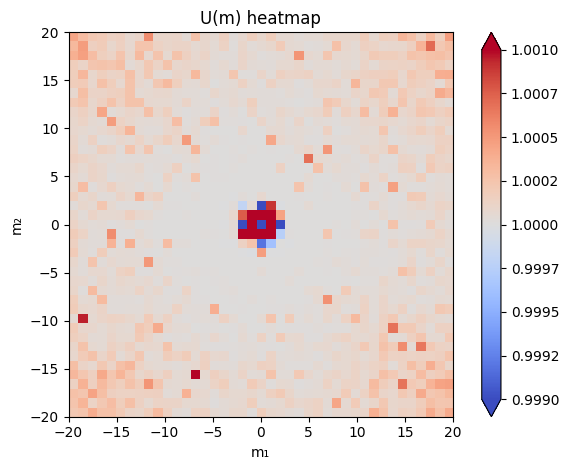

In [9]:
lo, hi = 0.999, 1.001

norm = TwoSlopeNorm(vmin=lo, vcenter=1.0, vmax=hi)

cmap = plt.get_cmap('coolwarm', 256)
plt.figure()
im = plt.imshow(
    Ugrid,
    extent=[ms[0], ms[-1], ms[0], ms[-1]],
    origin='lower',
    aspect='equal',
    cmap=cmap,
    norm=norm,
    interpolation='nearest'
)
cbar = plt.colorbar(im, ticks=np.linspace(lo, hi, 9), extend='both')
cbar.ax.set_yticklabels([f"{t:.4f}" for t in np.linspace(lo, hi, 9)])
plt.title('U(m) heatmap')
plt.xlabel('m₁')
plt.ylabel('m₂')
plt.tight_layout()
plt.show()

## Error Analysis

There are two sources of error in the computation: sampling error and truncation error.

### Sampling Error

We sampled i.i.d. $(V_{i}(m))_{i=1,2,\cdots,N}$ where $V_i(m) = \frac1{H_{S_i}(B_{S_i}/\sqrt2 + m/2)}$ and used the estimator
$$
\widehat U_N(m) = \frac{1}{N}\sum_{i=1}^N V_i(m).
$$

The estimator is unbiased $E[\widehat U_N(m)] = U(m)$ with variance $\mathrm{Var}(\widehat U_N(m)) = \frac{1}{N}\mathrm{Var}(V(m))$.

For each $m=(m_1, m_2)\in\mathbb{Z}^2$, the confidence interval for $\widehat U_N(m)$ is
$$
    \widehat U_N(m) \;\pm\; z_{1-\alpha/2}\,\frac{\widehat\sigma(m)}{\sqrt{N}},
$$
where $\widehat\sigma^2(m) = \frac1{N-1}\sum (V_i(m) - \widehat U_N(m))^2.$


### Bias from Lattice-Sum Truncation

We approximate  
$$
    H_{S}(x)=\sum_{k\in\mathbb Z^2}\frac1{2\pi S}\exp\!\Bigl(-\frac{\lVert x-k\rVert^2}{2S}\Bigr)
$$
by summing only over $|k_1|, |k_2|\le M$. That is, we replace $H_S$ with $\widehat H_S := H_S-R(M;S,x)$ where 
$$
R(M;S,x)
=\sum_{\lVert k\rVert_\infty> M}\frac1{2\pi S}e^{-\lVert x-k\rVert^2/(2S)}
\approx O\bigl(e^{-(M-\lVert x\rVert_\infty)^2/(2S)}\bigr).
$$
Each sample has a bias from this trunctation
$$
    V_i^\text{trunc}
    = \frac1{H-\Delta H}
    = \frac1H\Bigl(1 + O(\tfrac{\Delta H}{H})\Bigr)
    \approx O\bigl(e^{-\delta^2/2}\bigr)
$$
if $M = \tfrac12\max|m_i| + 3\sqrt S + \delta$.
So, the overall bias is also $O(e^{-\delta^2/2})$.


### Summary
$$
\bigl|\widehat U_N^\text{trunc}(m)-U(m)\bigr|
\;\lesssim\;
\underbrace{O\bigl(e^{-\delta^2/2}\bigr)}_{\text{truncation bias}}
\;+\;
\underbrace{O\bigl(\tfrac{\sigma_V}{\sqrt{N}}\bigr)}_{\text{Monte Carlo error}}.
$$

1. To reduce **Monte Carlo error** by $\varepsilon$, we choose $N\approx (\sigma_V/\varepsilon)^2$.
2. To reduce **truncation bias** by $\varepsilon$, we choose $\delta\approx\sqrt{2\ln(1/\varepsilon)}$.

